# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [15]:
# Import Data Processing/Representation Libraries
import numpy as np
import pandas as pd

# Import Graph plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Image I/O Libraries
## from skimage import io
import keras
from keras.preprocessing.image import load_img
from PIL import Image


# Import Text Processing Libraries
import glob
#from wordcloud import WordCloud,STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Simple Utilities
import string
import time
from collections import Counter

# Test Train Split Library 
from sklearn.model_selection import train_test_split

# Deep Learning Network libraries
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input

# Text to speech Libraries
## from gtts import gTTS
## from playsound import playsound

Let's read the dataset

Since we are going to work with time consuming activities, we will often make use of progressbar
Following block will install tqdm package needed for the progress bar

In [16]:
!pip install tqdm

In [17]:
from tqdm import tqdm

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



## Data Understanding Stage 1: Import the dataset and read image & captions into two seperate variables

As first stage in the pipeline, we will import the dataset and read in all images and corresponding captions

### Read all Images

In [18]:
#Import the dataset and read the image into a seperate variable

images='/Users/vinitsinha/Library/Mobile Documents/com~apple~CloudDocs/Vinit/Workspace/repos/github/repos/eye-for-blinds/data/Flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


### Read Captions

In [19]:
#Import the dataset and read the text file into a seperate variable
text_file = '/Users/vinitsinha/Library/Mobile Documents/com~apple~CloudDocs/Vinit/Workspace/repos/github/repos/eye-for-blinds/data/Flickr8k/captions.txt'
def load_doc(filename):
    
    text=open(filename).read()
    
    return text

doc = load_doc(text_file)
print(doc[:300])
print(len(doc))

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing
3319294


## Data Understanding Stage 2: Visualise both the images & text present in the dataset

As a quick visualization, we show 5 images and corresponding captions

#### Step 0: Utilitie to parse captions.txt 

Following section defines couple of utility functions to parse captions.txt file.
The Parsing logic pretty simple. We ignore the first line in captions.txt, since it contains the column name.
We then read each line and split it for comma character. String before comma would be image id an anything after that is the caption.

In [22]:
class CaptionsFileParser(object):
    def __init__(self, fileContent):
        self._file_content = fileContent
        self._image_id_list = []
        self._image_path_list = []
        self._captions_list = []
        
    def parse(self):
        import os
        for line in self._file_content.splitlines()[1:]:
            image_id, caption = line.split(',', 1)
            
            image_id = self._cleanup_image_id(image_id)
            caption = self._cleanup_captoin(caption)
            
            self._image_id_list.append( image_id.strip() )
            self._image_path_list.append( os.path.join(images, self._image_id_list[-1]) )
            self._captions_list.append( caption.strip() )
            
    def get_image_ids(self):
        return self._image_id_list 
    
    def get_image_paths(self):
        return self._image_path_list 
    
    def get_image_captions(self):
        return self._captions_list 
    
    def _cleanup_image_id(self, image_id):
        return image_id.strip()
    
    def _cleanup_captoin(self, caption):
        caption = caption.strip() 
        if caption.startswith('\'') and caption.endswith('\''):
            caption = caption[1:len(caption)-1]
        if caption.startswith('"') and caption.endswith('"'):
            caption = caption[1:len(caption)-1]
        
        return caption
    
    def visualize(self, image_id):
        image_index = self._image_id_list.index(image_id) 
        image_path = self._image_path_list[image_index]
        
        captions_indices = slice(image_index, image_index + 5)
        captions = self._captions_list[captions_indices]
        captions_multi_lines=("\n"*2).join(captions)
        
        fig, ax = plt.subplots()
        ax.set_axis_off()
        im=Image.open(image_path)
        w,h=im.size[0],im.size[-1]
        ax.imshow(im)
        ax.text(w+50,h,captions_multi_lines,fontsize=20,color='green')
        
    def vocabulary(self):
        from functools import reduce
        split_vocab =  map(lambda caption: caption.split(), self._captions_list)
        joined_vocab = reduce(
            lambda caption_list1, caption_list2: caption_list1 + caption_list2,
            tqdm(split_vocab, desc="Building Vocabulary:", unit='word')
        )
        return joined_vocab

#### Step 1: Invoke the parser

In following cell we create the parser object and parse Captions.txt file

In [23]:
parser = CaptionsFileParser(doc) 
parser.parse()

#### Step 2: Visualize Image and caption

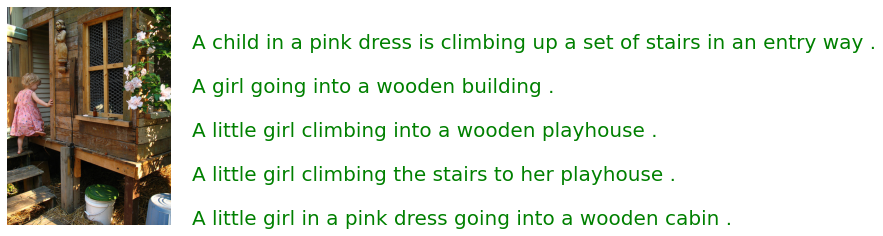

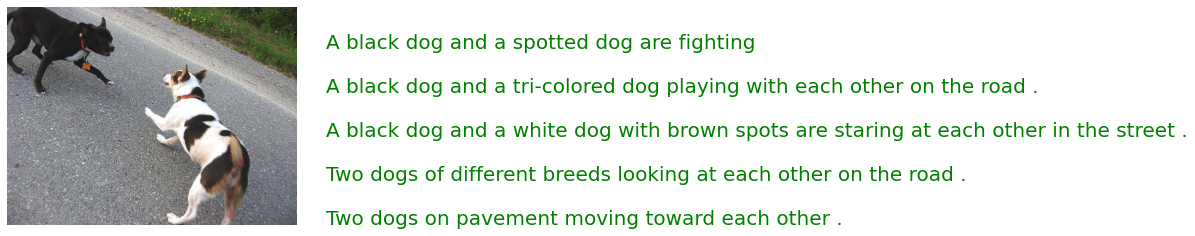

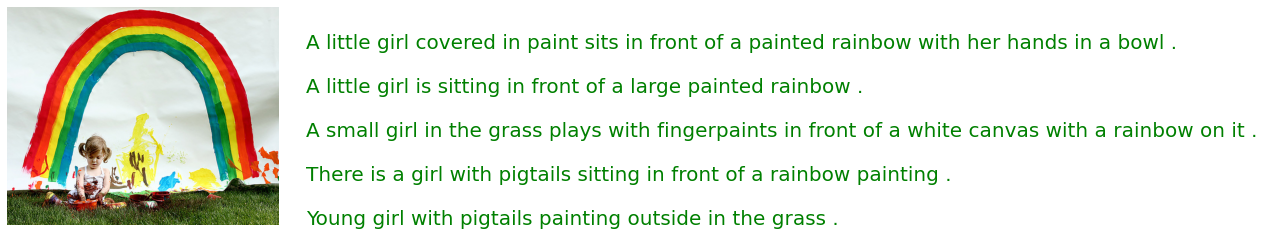

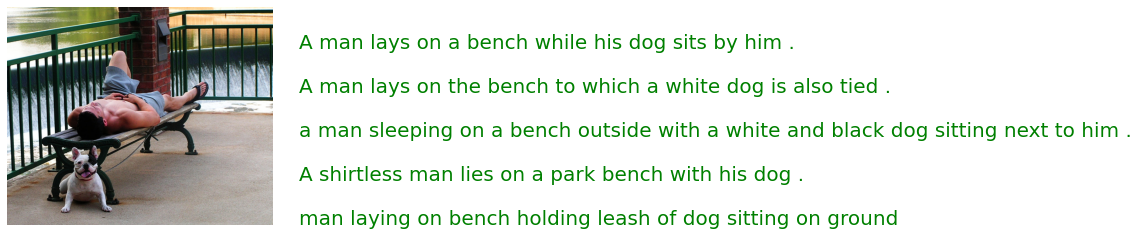

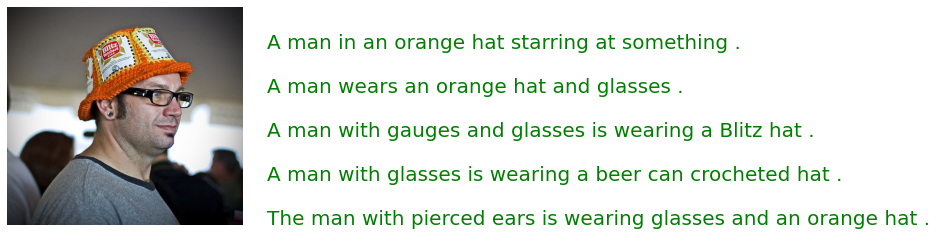

In [24]:
for i in range(0,5*5, 5):
    parser.visualize(parser.get_image_ids()[i])

## Data Understanding Stage 3: Create a dataframe which summarizes the image, path & captions as a dataframe

We now go aheda and create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [25]:
all_img_id = parser.get_image_ids()
all_img_vector = parser.get_image_paths()
annotations = parser.get_image_captions()

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/Users/vinitsinha/Library/Mobile Documents/com...,A rock climber in a red shirt .


## Data Understanding Stage 4: Create a list which contains all the captions

In [26]:
#Create a list which contains all the captions
annotations = df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path = df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Data Understanding Stage 5: Visualise the top 30 occuring words in the captions

#### Step 1: Create the vocabulary & the counter for the captions

As first step in visualizing top 30 words from the caption, we need to create vocabulary

In [27]:
#Create the vocabulary & the counter for the captions
vocabulary= parser.vocabulary()

val_count=Counter(vocabulary)
val_count

Building Vocabulary:: 40455word [02:38, 255.34word/s] 


Counter({'A': 22667,
         'child': 1477,
         'in': 18962,
         'a': 40319,
         'pink': 734,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1945,
         'entry': 1,
         'way': 50,
         '.': 36577,
         'girl': 3218,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7984,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 772,
         'on': 10730,
         'road': 388,
         'white': 3876,
         'brown': 2475,
         'spots': 29,
         'staring'

#### Step 2: Visualise the top 30 occuring words in the captions

<AxesSubplot:xlabel='Word', ylabel='Count'>

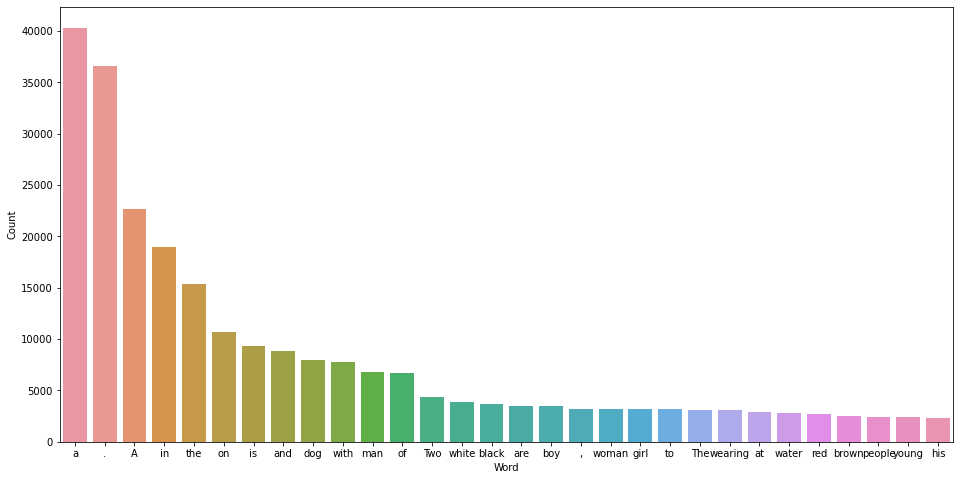

In [28]:
def most_common_words(counter,n):
    most_common_words_count_list = counter.most_common(n)
    most_common_words, most_common_count = zip(*most_common_words_count_list)
    return pd.DataFrame({
        'Word': most_common_words, 
        'Count': most_common_count
    })

top_30 = most_common_words(val_count,30)
plt.figure(figsize=(16,8))
sns.barplot(x=top_30.Word, y=top_30.Count)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Pre-Processing the captions Stage 1: create the tokenizer

In [29]:
top_word_cnt = 5000
tokenizer = Tokenizer(
    num_words=top_word_cnt,
    oov_token="<unk>",
    filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

### Pre-Processing the captions Stage 2: Create word-to-index and index-to-word mappings.

In [30]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

### Pre-Processing the captions Stage 3: Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

<AxesSubplot:xlabel='Word', ylabel='Count'>

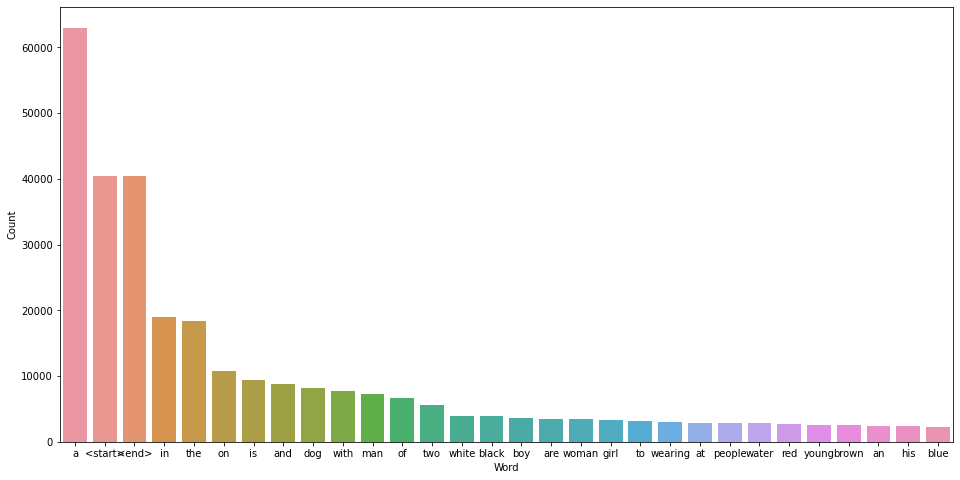

In [31]:
top_30 = most_common_words(Counter(tokenizer.word_counts),30)
plt.figure(figsize=(16,8))
sns.barplot(x=top_30.Word, y=top_30.Count)

### Pre-Processing the captions Stage 4: Pad each vector to the max_length of the captions ^ store it to a vairable

#### Step 1: Find the size of longest caption

In order to pad all captoion and bring to same size, we first need to decide the length of longest caption.

Following cell defines a function for that

In [32]:
def size_of_longest_caption(seq):
    len_seqs = map(
        lambda caption_seq: len(caption_seq),
        seq
    )
    return max(len_seqs)

len_congest_caption = size_of_longest_caption(train_seqs)
print('Size of longest Caption is',  len_congest_caption)
    

Size of longest Caption is 39


#### Step 2: pad each vector to the size of longest caption

In [33]:
cap_vector= pad_sequences(train_seqs,padding='post',maxlen=len_congest_caption)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [34]:
#write your code here to create the dataset consisting of image paths

In [35]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    from tensorflow.io import read_file
    from tensorflow.image import decode_jpeg
    from tensorflow.image import resize
    
    loaded_image = read_file(image_path)
    decoded_image = decode_jpeg(loaded_image, channels=3)
    resized_image = resize(decoded_image, (299, 299))
    prepocessed_image_for_inceptionV3 = preprocess_input(resized_image)
    return prepocessed_image_for_inceptionV3,image_path

In [36]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

def create_image_dataset(image_vector, batch_size=32):
    from tensorflow.data import Dataset
    from tensorflow.data.experimental import AUTOTUNE
    
    sorted_unique_image_vector = sorted(set(image_vector))
    image_data_set_slizes = Dataset.from_tensor_slices(sorted_unique_image_vector)
    
    image_data_set = image_data_set_slizes.map(load_image, num_parallel_calls=AUTOTUNE)
    return image_data_set.batch(batch_size)

image_dataset = create_image_dataset(all_img_vector)
image_dataset

2021-11-05 18:47:23.257204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [37]:
image_model = InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = Model(new_input, hidden_layer) 

In [38]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

In [39]:
!pip install tqdm

In [42]:
def load_or_create_features(dataset, features_file):
    import tensorflow
    from os.path import isfile
    feature_dict = dict()
    if isfile(features_file):
        feature_dict = np.load(features_file)
    else:
        for image,path in tqdm(image_dataset, desc='Building Dataset: '):
            batch_features = image_features_extract_model(image)
            batch_features = tensorflow.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
            for batch_f, p in zip(batch_features, path):
                path_of_feature = p.numpy().decode("utf-8")
                feature_dict[path_of_feature] =  batch_f.numpy()
        np.save(features_file, feature_dict)

In [43]:
feature_dict = load_or_create_features(image_dataset, 'features.pkl')

Building Dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [27:25<00:00,  6.50s/it]


TypeError: expected str, bytes or os.PathLike object, not dict

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split( #your code goes here)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

In [ ]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(# your input variable goes here):
  img_tensor = # write your code here to extract the features from the dictionary stored earlier
  return 

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(#your input variables):
    
    # your code goes here to create the dataset & transform it
    
    
    return dataset



In [ ]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = #top 5,000 words +1
train_num_steps = =#len(total train images) // BATCH_SIZE
test_num_steps = #len(total test images) // BATCH_SIZE

### Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = #build your Dense layer with relu activation
        
    def call(self, features):
        features =  # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = #build your Dense layer
        self.W2 = #build your Dense layer
        self.V = #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = #iniitalise your Attention model with units
        self.embed = #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = #build your Dense layer
        self.d2 = #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = #create your context vector & attention weights from attention model
        embed =  # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = #define the optimizer
loss_object = #define your loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "your checkpoint path"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
        
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    
    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption



In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)